<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [138]:
from bs4 import BeautifulSoup
import requests

jobs = pd.read_csv("./data/job_listings.csv")

In [139]:
def clean_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    sans_tags = soup.get_text()
    sans_unicode = eval(sans_tags).decode("utf-8", "replace")
    string = sans_unicode.replace('\n', ' ').strip()
    
    return string

In [140]:
jobs["description"] = jobs["description"].apply(clean_text)
jobs = jobs.drop(columns=['Unnamed: 0'])
jobs.head()

,description,title
0,Job Requirements: Conceptual understanding in ...,Data scientist
1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist
4,Location: USA – multiple locations 2+ years of...,Data Scientist
...,...,...
421,About Us: Want to be part of a fantastic and f...,Senior Data Science Engineer
422,"InternshipAt Uber, we ignite opportunity by se...",2019 PhD Data Scientist Internship - Forecasti...
423,"$200,000 - $350,000 a yearA million people a y...",Data Scientist - Insurance
424,SENIOR DATA SCIENTIST JOB DESCRIPTION ABOUT U...,Senior Data Scientist


## 2) Use Spacy to tokenize the listings 

In [143]:
# get core web lg
nlp = spacy.load("en_core_web_lg")

In [148]:
# tokenize listings


def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    
    for token in doc:
        if (
              ((token.is_stop == False) and 
              (token.is_punct == False)) and
              (token.pos_ != "PRON")):
                lemmas.append(token.lemma_)
        
    return lemmas  

In [149]:
jobs["tokens"] = jobs["description"].apply(get_lemmas)

In [150]:
jobs.head()

,description,title,tokens
0,Job Requirements: Conceptual understanding in ...,Data scientist,"[job, requirement, conceptual, understanding, ..."
1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I,"[job, description, , Data, scientist, 1, help..."
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[Data, scientist, work, consult, business, res..."
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$, 4,969, $, 6,756, monthcontractunder, gener..."
4,Location: USA – multiple locations 2+ years of...,Data Scientist,"[location, USA, multiple, location, 2, +, year..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [151]:
vect = CountVectorizer()

vect.fit(jobs["description"])

dtm = vect.transform(jobs["description"])

In [153]:
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,ﬁeld,ﬁnd,ﬁndings
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [169]:
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

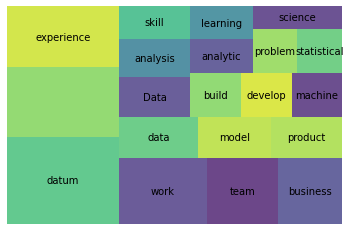

In [170]:
import squarify

wc = count(jobs["tokens"])
top_20 = wc[wc["rank"] <= 20]

squarify.plot(sizes=top_20["pct_total"], label=top_20["word"], alpha=.8)
plt.axis("off")
plt.show()


## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [172]:
tfidf = TfidfVectorizer(stop_words="english")

dtm = tfidf.fit_transform(jobs["description"])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zheng,zillow,zogsports,zones,zoom,zuckerberg,zurich,ﬁeld,ﬁnd,ﬁndings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.106253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [174]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [176]:
nn.kneighbors([dtm.iloc[233]])

(array([[0.        , 0.        , 1.03618704, 1.20668296, 1.20668296]]),
 array([[389, 233, 327, 184, 147]]))

In [187]:
jobs["description"].iloc[233][:200]

'Position Summary: Under general direction, the Data Scientist leads activities related to the design, development, implementation, and support of mathematical models and machine learning products deli'

In [188]:
jobs["description"].iloc[327][:200]

'If you’re ready to innovate and help lead the development for Hewlett Packard Enterprise’s (HPE) Analytics Platform, come join us now! You will be part of an organization that is revolutionizing repor'

In [199]:
my_description = ["""
Create machine learning models for self driving cars
"""]

In [200]:
mine = tfidf.transform(my_description)
nn.kneighbors(mine.todense())

(array([[1.22012362, 1.2628444 , 1.27030069, 1.27030069, 1.32095992]]),
 array([[ 89,  51, 214,  77, 316]]))

In [202]:
jobs['description'].iloc[316]

"Nauto is an AI technology company that's improving the safety of commercial fleets today and the autonomous fleets of tomorrow. Nauto's intelligent driver safety system assesses how drivers interact with the vehicle and the road ahead to reduce distracted driving and prevent collisions. With this knowledge, Nauto is powering the development of self-driving technology that brings the best of human driving to autonomy. Are you ready to help with this mission?  We're aiming for greater safety and knowledge: Our approach to re-thinking road safety is two-fold: deepen our understanding of real-world drivers to learn how they interact with the vehicle and road, with the goal of reducing distracted driving and preventing collisions before they occur. Second, apply these insights to the development of safe, effective autonomous vehicles that fit into existing traffic patterns and human driving behavior.  We're taking a driver-centric approach: We surface the safety insights that matter most, 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 